# 3rd Down Conversion Predictor

## Import and Setup

In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

#Code for colab comment out if not on colab
# from google.colab import files

from sklearn.model_selection import train_test_split
%matplotlib inline

# Check GPU
# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   raise SystemError('GPU device not found')
# print('Found GPU at: {}'.format(device_name))

In [2]:
### Code for colab comment out if not on colab
# uploaded = files.upload()

# for name, data in uploaded.items():
#   with open(name, 'wb') as f:
#     f.write(data)
#     print ('saved file', name)
###

## Data Preparation

In [3]:
# Load data into dataframe
data_filepath = "pbp-2016.csv"
df = pd.read_csv(data_filepath)

In [4]:
# Print available columns from data
print(df.columns)

Index(['GameId', 'GameDate', 'Quarter', 'Minute', 'Second', 'OffenseTeam',
       'DefenseTeam', 'Down', 'ToGo', 'YardLine', 'Unnamed: 10',
       'SeriesFirstDown', 'Unnamed: 12', 'NextScore', 'Description', 'TeamWin',
       'Unnamed: 16', 'Unnamed: 17', 'SeasonYear', 'Yards', 'Formation',
       'PlayType', 'IsRush', 'IsPass', 'IsIncomplete', 'IsTouchdown',
       'PassType', 'IsSack', 'IsChallenge', 'IsChallengeReversed',
       'Challenger', 'IsMeasurement', 'IsInterception', 'IsFumble',
       'IsPenalty', 'IsTwoPointConversion', 'IsTwoPointConversionSuccessful',
       'RushDirection', 'YardLineFixed', 'YardLineDirection',
       'IsPenaltyAccepted', 'PenaltyTeam', 'IsNoPlay', 'PenaltyType',
       'PenaltyYards'],
      dtype='object')


In [5]:
features_to_use = ['Quarter', 'Minute', 'Second', 'OffenseTeam', 'DefenseTeam', 'Down', 'ToGo', 'YardLine', 'Formation', 'PlayType', 'IsRush', 'IsPass', 'Yards', 'PassType']


In [6]:
# Select features
df = df[features_to_use]

In [7]:
# Isolate plays to ones that were on 3rd down and converted
df = df.loc[df['Down'] == 3]
df = df.loc[df['PlayType'].isin(['PASS', 'RUSH', 'SCRAMBLE'])]
df['Conversion'] = (df['Yards'] >= df['ToGo']).astype(int)

In [8]:
raw_matrix = df.values

In [9]:
# Delete row with strange PassType
df = df.loc[df['PassType'] != '(6:41) (SHOTGUN)']

In [10]:
print(set(df['PassType']))

{nan, 'SHORT RIGHT', 'NOT LISTED', 'INTENDED FOR', 'DEEP LEFT', 'SHORT MIDDLE', 'RIGHT. PENALTY', 'DEEP MIDDLE', 'SHORT LEFT', 'DEEP RIGHT'}


In [11]:
df = df.loc[df['PassType'] != 'RIGHT. PENALTY']

In [12]:
df = df.loc[df['PassType'] != 'INTENDED FOR']

In [13]:
df = df.loc[df['PassType'] != 'NOT LISTED']

In [14]:
df = df.loc[df['PassType'].notnull()]

In [15]:
# One hot encoded features
df = df.join(pd.get_dummies(df['Formation']))
df = df.join(pd.get_dummies(df['OffenseTeam'], prefix = 'Offense'))
df = df.join(pd.get_dummies(df['DefenseTeam'], prefix = 'Defense'))
df = df.join(pd.get_dummies(df['PlayType']))
df = df.join(pd.get_dummies(df['PassType']))
# df = df.join(pd.get_dummies(df['Conversion', prefix = 'Conversion']))

In [16]:
df = df.drop(columns=['OffenseTeam', 'DefenseTeam', 'Formation', 'PlayType', 'PassType', 'Yards'])

In [17]:
df.columns

Index(['Quarter', 'Minute', 'Second', 'Down', 'ToGo', 'YardLine', 'IsRush',
       'IsPass', 'Conversion', 'NO HUDDLE', 'NO HUDDLE SHOTGUN', 'SHOTGUN',
       'UNDER CENTER', 'Offense_ARI', 'Offense_ATL', 'Offense_BAL',
       'Offense_BUF', 'Offense_CAR', 'Offense_CHI', 'Offense_CIN',
       'Offense_CLE', 'Offense_DAL', 'Offense_DEN', 'Offense_DET',
       'Offense_GB', 'Offense_HOU', 'Offense_IND', 'Offense_JAX', 'Offense_KC',
       'Offense_LA', 'Offense_MIA', 'Offense_MIN', 'Offense_NE', 'Offense_NO',
       'Offense_NYG', 'Offense_NYJ', 'Offense_OAK', 'Offense_PHI',
       'Offense_PIT', 'Offense_SD', 'Offense_SEA', 'Offense_SF', 'Offense_TB',
       'Offense_TEN', 'Offense_WAS', 'Defense_ARI', 'Defense_ATL',
       'Defense_BAL', 'Defense_BUF', 'Defense_CAR', 'Defense_CHI',
       'Defense_CIN', 'Defense_CLE', 'Defense_DAL', 'Defense_DEN',
       'Defense_DET', 'Defense_GB', 'Defense_HOU', 'Defense_IND',
       'Defense_JAX', 'Defense_KC', 'Defense_LA', 'Defense_MIA', 'Defense_

In [18]:
df.iloc[0]

Quarter               2
Minute                1
Second               26
Down                  3
ToGo                  4
YardLine             53
IsRush                0
IsPass                1
Conversion            0
NO HUDDLE             0
NO HUDDLE SHOTGUN     0
SHOTGUN               1
UNDER CENTER          0
Offense_ARI           0
Offense_ATL           0
Offense_BAL           0
Offense_BUF           0
Offense_CAR           0
Offense_CHI           0
Offense_CIN           0
Offense_CLE           0
Offense_DAL           0
Offense_DEN           0
Offense_DET           0
Offense_GB            0
Offense_HOU           0
Offense_IND           0
Offense_JAX           0
Offense_KC            0
Offense_LA            0
                     ..
Defense_DEN           0
Defense_DET           0
Defense_GB            0
Defense_HOU           0
Defense_IND           0
Defense_JAX           0
Defense_KC            0
Defense_LA            0
Defense_MIA           0
Defense_MIN           0
Defense_NE      

## Model Training & Validation

In [19]:
conversion_labels = df.pop('Conversion').as_matrix()
data_mat = df.as_matrix()

In [20]:
df.columns

Index(['Quarter', 'Minute', 'Second', 'Down', 'ToGo', 'YardLine', 'IsRush',
       'IsPass', 'NO HUDDLE', 'NO HUDDLE SHOTGUN', 'SHOTGUN', 'UNDER CENTER',
       'Offense_ARI', 'Offense_ATL', 'Offense_BAL', 'Offense_BUF',
       'Offense_CAR', 'Offense_CHI', 'Offense_CIN', 'Offense_CLE',
       'Offense_DAL', 'Offense_DEN', 'Offense_DET', 'Offense_GB',
       'Offense_HOU', 'Offense_IND', 'Offense_JAX', 'Offense_KC', 'Offense_LA',
       'Offense_MIA', 'Offense_MIN', 'Offense_NE', 'Offense_NO', 'Offense_NYG',
       'Offense_NYJ', 'Offense_OAK', 'Offense_PHI', 'Offense_PIT',
       'Offense_SD', 'Offense_SEA', 'Offense_SF', 'Offense_TB', 'Offense_TEN',
       'Offense_WAS', 'Defense_ARI', 'Defense_ATL', 'Defense_BAL',
       'Defense_BUF', 'Defense_CAR', 'Defense_CHI', 'Defense_CIN',
       'Defense_CLE', 'Defense_DAL', 'Defense_DEN', 'Defense_DET',
       'Defense_GB', 'Defense_HOU', 'Defense_IND', 'Defense_JAX', 'Defense_KC',
       'Defense_LA', 'Defense_MIA', 'Defense_MIN', 'Defense

In [21]:
X_train, X_test, y_train, y_test = train_test_split(data_mat, conversion_labels, test_size=0.33, random_state=42)

In [22]:
print(sum(y_test)/len(y_test))
from sklearn.decomposition import PCA
# Make an instance of the Model
pca = PCA(.99)

pca.fit(X_train)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

0.4110535405872193


In [23]:
class BortlesModel:
    def __init__(self, input_dimension, learning_rate=0.5):
        self.learning_rate = learning_rate
        self.weight_path = 'bortles_weights.csv'
        self.bias_path = 'bortles_bias.csv'
        self.construct_model(input_dimension)
    
    def construct_model(self, input_dimension):
        self.input_data = tf.placeholder(tf.float32, (None, input_dimension))
        self.labels = tf.placeholder(tf.int32, (None,))
        self.weights = tf.Variable(tf.random_normal((input_dimension, 2)))
        self.bias = tf.Variable(tf.random_normal((2,)))
        
        self.output = tf.matmul(self.input_data, self.weights) + self.bias

        # Cross Entropy
        self.cost = tf.reduce_mean(
            tf.nn.sparse_softmax_cross_entropy_with_logits(labels=self.labels, logits=self.output))
        
        self.optimizer = tf.train.GradientDescentOptimizer(self.learning_rate).minimize(self.cost)
    
    def train_model(self, train_data, train_labels, num_iter=1000, use_stored_params=False):
        if use_stored_params:
            weights = np.loadtxt(self.weight_path)
            bias = np.loadtxt(self.bias_path)
            tf.assign(self.weights, weights)
            tf.assign(self.bias, bias)
        init = tf.global_variables_initializer()
        losses = []
        
        with tf.Session() as sess:
            # Initialize the variables.
            sess.run(init)
            
            for i in range(num_iter):
                _, loss_val = sess.run([self.optimizer, self.cost], feed_dict={self.input_data: train_data, self.labels: train_labels})
                losses.append(loss_val)
                if i % 100 == 0:
                    print(i)
                    print(loss_val)
            
            weights = sess.run(self.weights)
            bias = sess.run(self.bias)
        
        return np.array(losses), weights, bias
    
    def apply_model(self, weights, bias, data, labels):
        init = tf.global_variables_initializer()
        with tf.Session() as sess:
            sess.run(init)
            
            logits = sess.run(self.output, feed_dict={self.input_data: data, self.labels: labels, self.weights: weights, self.bias: bias})
            pred_labels = sess.run(tf.argmax(logits, 1))
        
        return pred_labels
    
    def store_weights_and_bias(self, weights, bias):
        np.savetxt(self.weight_path, weights)
        np.savetxt(self.bias_path, bias)

In [24]:
bortles = BortlesModel(input_dimension=X_train.shape[1], learning_rate=0.005)

In [26]:
loss, weights, bias = bortles.train_model(X_train, y_train, num_iter=5000)

0
34.93094
100
0.71141565
200
0.6813642
300
0.66675013
400
0.6559036
500
0.64803123
600
0.64243126
700
0.6385136
800
0.6358087
900
0.63396096
1000
0.6327087
1100
0.6318661
1200
0.6313021
1300
0.63092613
1400
0.6306758
1500
0.63051015
1600
0.6304005
1700
0.6303281
1800
0.6302805
1900
0.63024914
2000
0.6302283
2100
0.6302146
2200
0.6302058
2300
0.63019985
2400
0.6301961
2500
0.63019353
2600
0.6301915
2700
0.63019085
2800
0.63019013
2900
0.6301894
3000
0.63018936
3100
0.6301889
3200
0.630189
3300
0.6301891
3400
0.6301889
3500
0.6301888
3600
0.6301888
3700
0.6301887
3800
0.63018847
3900
0.6301886
4000
0.6301887
4100
0.6301887
4200
0.6301886
4300
0.6301886
4400
0.63018876
4500
0.63018876
4600
0.6301889
4700
0.6301889
4800
0.63018876
4900
0.63018847


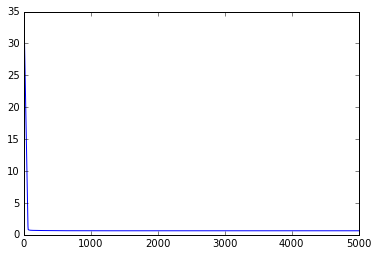

In [27]:
plt.plot(loss)

In [28]:
# Store model weights
bortles.store_weights_and_bias(weights, bias)

In [29]:
### ONLY RUN IF weights and bias stored from previous run
# loss, weights, bias = bortles.train_model(X_train, y_train, num_iter=200, use_stored_params=True)

In [30]:
# Apply model and see training error
pred_labels = bortles.apply_model(data=X_train, labels=y_train, weights=weights, bias=bias)

In [31]:
# See training error
num_match = 0
for i in range(len(y_train)):
    if y_train[i] == pred_labels[i]:
        num_match += 1

print('Training Error:', num_match / len(y_train))

Training Error: 0.6288308740068105


In [32]:
pred_labels_test = bortles.apply_model(data=X_test, labels=y_test, weights=weights, bias=bias)
# See test error
num_match = 0
for i in range(len(y_test)):
    if y_test[i] == pred_labels_test[i]:
        num_match += 1

print('Test Error:', num_match / len(y_test))

Test Error: 0.6229130685089235
